In [97]:
import numpy as np
import optuna
import pandas as pd
import openml
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold



In [98]:
dataset = openml.datasets.get_dataset("wine-quality-white")
data, _, _, attribute_names = dataset.get_data(target=None)
X = data.drop(["Class"], axis=1)
y = data["Class"].astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   V1      4898 non-null   float64 
 1   V2      4898 non-null   float64 
 2   V3      4898 non-null   float64 
 3   V4      4898 non-null   float64 
 4   V5      4898 non-null   float64 
 5   V6      4898 non-null   float64 
 6   V7      4898 non-null   float64 
 7   V8      4898 non-null   float64 
 8   V9      4898 non-null   float64 
 9   V10     4898 non-null   float64 
 10  V11     4898 non-null   float64 
 11  Class   4898 non-null   category
dtypes: category(1), float64(11)
memory usage: 426.2 KB


<BarContainer object of 7 artists>

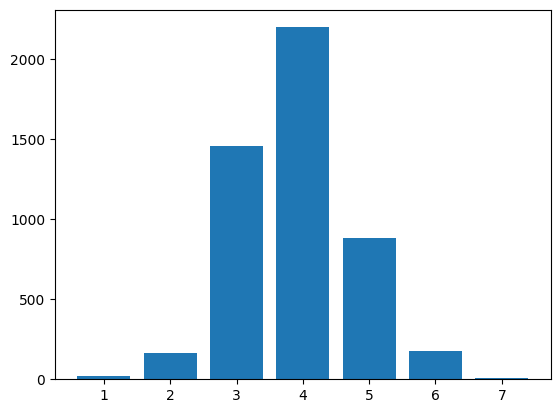

In [99]:
y_hist = np.unique(y, return_counts=True)
plt.bar(y_hist[0], y_hist[1])

array([[<Axes: xlabel='V1', ylabel='V1'>,
        <Axes: xlabel='V2', ylabel='V1'>,
        <Axes: xlabel='V3', ylabel='V1'>,
        <Axes: xlabel='V4', ylabel='V1'>,
        <Axes: xlabel='V5', ylabel='V1'>,
        <Axes: xlabel='V6', ylabel='V1'>,
        <Axes: xlabel='V7', ylabel='V1'>,
        <Axes: xlabel='V8', ylabel='V1'>,
        <Axes: xlabel='V9', ylabel='V1'>,
        <Axes: xlabel='V10', ylabel='V1'>,
        <Axes: xlabel='V11', ylabel='V1'>],
       [<Axes: xlabel='V1', ylabel='V2'>,
        <Axes: xlabel='V2', ylabel='V2'>,
        <Axes: xlabel='V3', ylabel='V2'>,
        <Axes: xlabel='V4', ylabel='V2'>,
        <Axes: xlabel='V5', ylabel='V2'>,
        <Axes: xlabel='V6', ylabel='V2'>,
        <Axes: xlabel='V7', ylabel='V2'>,
        <Axes: xlabel='V8', ylabel='V2'>,
        <Axes: xlabel='V9', ylabel='V2'>,
        <Axes: xlabel='V10', ylabel='V2'>,
        <Axes: xlabel='V11', ylabel='V2'>],
       [<Axes: xlabel='V1', ylabel='V3'>,
        <Axes: xlabel='V2', 

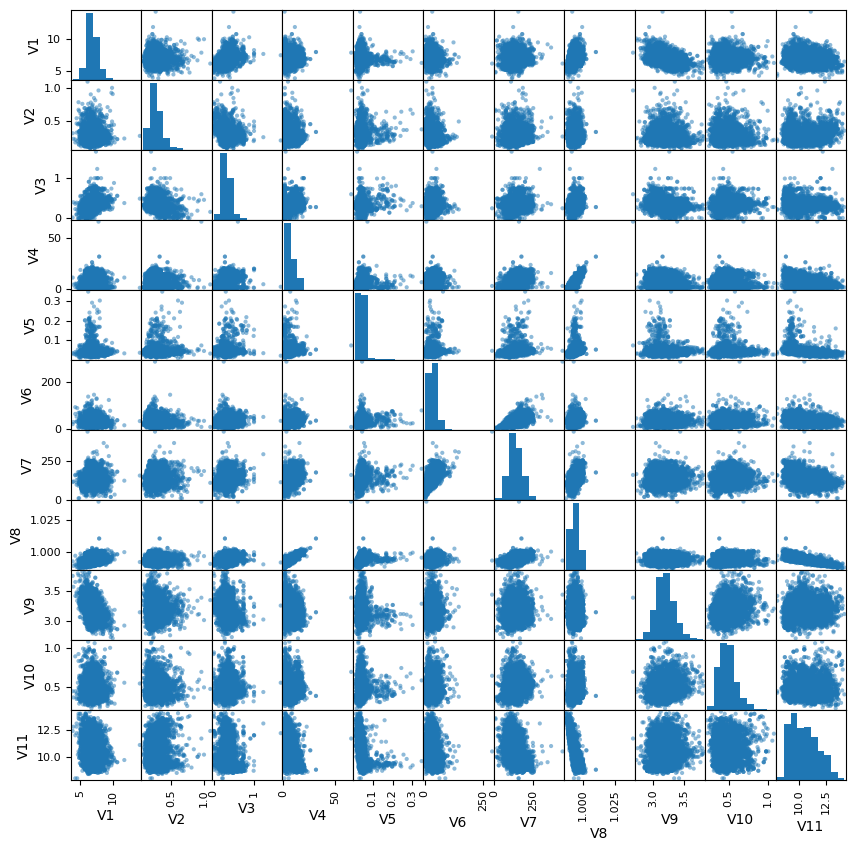

In [100]:
pd.plotting.scatter_matrix(data, figsize=(10, 10))

In [101]:
corr = X.corr()
corr

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
V1,1.000000,-0.022697,0.289181,0.089021,0.023086,-0.049396,0.091070,0.265331,-0.425858,-0.017143,-0.120881
V2,-0.022697,1.000000,-0.149472,0.064286,0.070512,-0.097012,0.089261,0.027114,-0.031915,-0.035728,0.067718
V3,0.289181,-0.149472,1.000000,0.094212,0.114364,0.094077,0.121131,0.149503,-0.163748,0.062331,-0.075729
V4,0.089021,0.064286,0.094212,1.000000,0.088685,0.299098,0.401439,0.838966,-0.194133,-0.026664,-0.450631
V5,0.023086,0.070512,0.114364,0.088685,1.000000,0.101392,0.198910,0.257211,-0.090439,0.016763,-0.360189
V6,-0.049396,-0.097012,0.094077,0.299098,0.101392,1.000000,0.615501,0.294210,-0.000618,0.059217,-0.250104
V7,0.091070,0.089261,0.121131,0.401439,0.198910,0.615501,1.000000,0.529881,0.002321,0.134562,-0.448892
V8,0.265331,0.027114,0.149503,0.838966,0.257211,0.294210,0.529881,1.000000,-0.093591,0.074493,-0.780138
V9,-0.425858,-0.031915,-0.163748,-0.194133,-0.090439,-0.000618,0.002321,-0.093591,1.000000,0.155951,0.121432
V10,-0.017143,-0.035728,0.062331,-0.026664,0.016763,0.059217,0.134562,0.074493,0.155951,1.000000,-0.017433


In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3918, 11), (980, 11), (3918,), (980,))

In [103]:
np.quantile(X, (0.025, 0.975), axis=0)

array([[5.3000e+00, 1.4000e-01, 1.3000e-01, 1.0000e+00, 2.4000e-02,
        8.0000e+00, 6.5425e+01, 9.8926e-01, 2.9200e+00, 3.2000e-01,
        8.8000e+00],
       [8.7575e+00, 5.4000e-01, 6.4000e-01, 1.7500e+01, 9.4575e-02,
        6.9000e+01, 2.2500e+02, 9.9976e-01, 3.5200e+00, 7.7000e-01,
        1.3000e+01]])

In [104]:
full_model = LinearRegression(fit_intercept=True)
result = full_model.fit(X_train, y_train)


In [124]:
def own_cross_val_score(model) -> np.ndarray:
    scores = np.zeros(5)

    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        xtr = X_train.iloc[train_index, :]
        ytr = y_train.iloc[train_index]

        model.model(xtr, ytr)

        xte = X_train.iloc[test_index, :]
        yte = y_train.iloc[test_index]
        # preds = model.predict(xte)[:, 1]

        scores[i] = model.score(xte, yte)  # R^2

    return scores


In [106]:
def create_model_using_params(ModelClass, best_params: dict) -> object:
    k_best = best_params["k_best"]
    just_params = best_params.copy()
    del just_params["k_best"]  # fixes Unexpected keyword in Model constructor

    model = Pipeline([
        ("selector", SelectKBest(k=k_best)),
        ("model", ModelClass(**just_params)),
    ])
    return model

In [107]:
def objective_rf(trial):
    params = dict(
        k_best = trial.suggest_int("k_best", 1, X.shape[1]),
        n_estimators = trial.suggest_int("n_estimators", 50, 300),
        max_depth = trial.suggest_int("max_depth", 3, 20),
        min_samples_split = trial.suggest_int("min_samples_split", 2, 20),
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10),
    )

    model = create_model_using_params(RandomForestRegressor, params)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    model = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1).mean()
    return model

In [108]:
rf_study = optuna.create_study(study_name="RandomForest", direction='maximize', sampler=optuna.samplers.RandomSampler(42))
rf_study.optimize(objective_rf, n_trials=100)

[I 2025-11-26 16:53:38,292] A new study created in memory with name: RandomForest
[I 2025-11-26 16:53:41,108] Trial 0 finished with value: -0.4751504229070438 and parameters: {'k_best': 5, 'n_estimators': 288, 'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 0 with value: -0.4751504229070438.
[I 2025-11-26 16:53:41,427] Trial 1 finished with value: -0.6096373397520141 and parameters: {'k_best': 2, 'n_estimators': 64, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 8}. Best is trial 0 with value: -0.4751504229070438.
[I 2025-11-26 16:53:42,017] Trial 2 finished with value: -0.6307587784249884 and parameters: {'k_best': 1, 'n_estimators': 293, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: -0.4751504229070438.
[I 2025-11-26 16:53:42,780] Trial 3 finished with value: -0.5272998713394489 and parameters: {'k_best': 3, 'n_estimators': 126, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 3

In [109]:
rf_study.best_params

{'k_best': 11,
 'n_estimators': 289,
 'max_depth': 19,
 'min_samples_split': 9,
 'min_samples_leaf': 1}

In [112]:
best_rf_model = create_model_using_params(RandomForestRegressor, rf_study.best_params)
best_rf_model.fit(X_train, y_train)


In [114]:
y_pred = best_rf_model.predict(X_test)
y_pred[0], y_test.iloc[0]

(3.3912006948818045, 4.0)

In [126]:
indices = np.arange(X_train.shape[0])

models = []
cv = KFold(n_splits=10, shuffle=True, random_state=42)
for train_idx, test_idx in cv.split(X_train, y_train):
    # indices_boot = np.random.choice(indices, size=X_train.shape[0], replace=True)
    # X_boot = X_train[indices_boot, :]
    # y_train = y_train.iloc[indices_boot]
    xtr = X_train[train_idx, :]
    ytr = y_train.iloc[train_idx]
    model = create_model_using_params(RandomForestRegressor, rf_study.best_params)
    model.fit(xtr, ytr)
    models.append(model)


In [131]:
preds = np.array([model.predict(X_test) for model in models])

In [132]:
[preds[i][0] for i in range(len(preds))]

[4.060569658202491,
 4.047033680341508,
 4.063904528275398,
 4.0696851041788555,
 4.068816868868631,
 4.005553164408491,
 4.1037558048975615,
 3.7776190382260952,
 4.085298204753895,
 4.0350118931418955]

In [142]:
preds_discreate = preds.mean(axis=0).round().astype(int)
preds_discreate

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4,
       4, 4, 5, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4,
       4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4,